In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import torchvision

Mounted at /content/drive


In [ ]:
import argparse
import os
import numpy as np
import math
from tqdm.autonotebook import tqdm
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

os.makedirs("images", exist_ok=True)

class args :
  n_epochs = 200
  batch_size = 64
  lr = 0.0002
  b1 = 0.5
  b2 = 0.999
  n_cpu = 8
  latent_dim = 100
  n_classes = 10
  img_size = 32
  channels = 1ㄴ
  sample_interval = 5000
  num_iter = 1000
  n_row = 10

#parser = argparse.ArgumentParser()
#parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
#parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
#parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
#parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
#parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
#parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
#parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
#parser.add_argument("--n_classes", type=int, default=10, help="number of classes for dataset")
#parser.add_argument("--img_size", type=int, default=32, help="size of each image dimension")
#parser.add_argument("--channels", type=int, default=1, help="number of image channels")
#parser.add_argument("--sample_interval", type=int, default=400, help="interval between image sampling")

opt = args
#opt = parser.parse_args()
print(opt)

img_shape = (opt.channels, opt.img_size, opt.img_size)

cuda = True if torch.cuda.is_available() else False

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(opt.n_classes, opt.n_classes)
        # 10 dimension x 10 embeddings

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim + opt.n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(opt.n_classes, opt.n_classes)
        self.model = nn.Sequential(
            nn.Linear(opt.n_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

# Loss functions
adversarial_loss = torch.nn.MSELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor


def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, opt.latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = generator(z, labels)
    #gen_imgs = gen_imgs.cpu()
    #torchvision.io.write_png(gen_imgs, '/content/drive/My Drive/Colab Notebooks/GAN_project/Images.png')
    save_image(gen_imgs.data, "/content/drive/My Drive/Colab Notebooks/GAN_project/imgs/%d.png" % batches_done, nrow=n_row, normalize=True)

# ----------
#  Training
# ----------

for epoch in range(opt.n_epochs):
    cnt = 0
    generator.train()
    discriminator.train()

    progress = tqdm(enumerate(dataloader), total = len(dataloader))
    for i, (imgs, labels) in progress:
        cnt += 1
        batch_size = imgs.shape[0]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(FloatTensor))
        labels = Variable(labels.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, opt.latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, opt.n_classes, batch_size)))

        # Generate a batch of images

        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        if cnt % 400 == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
            )

        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            sample_image(n_row=10, batches_done=batches_done)

<class '__main__.args'>


[Epoch 0/200] [Batch 399/938] [D loss: 0.179671] [G loss: 0.208120]
[Epoch 0/200] [Batch 799/938] [D loss: 0.146728] [G loss: 0.272800]



[Epoch 1/200] [Batch 399/938] [D loss: 0.091850] [G loss: 0.638443]
[Epoch 1/200] [Batch 799/938] [D loss: 0.076323] [G loss: 0.692478]



[Epoch 2/200] [Batch 399/938] [D loss: 0.164196] [G loss: 1.070554]
[Epoch 2/200] [Batch 799/938] [D loss: 0.112273] [G loss: 0.518147]



[Epoch 3/200] [Batch 399/938] [D loss: 0.133730] [G loss: 0.477757]
[Epoch 3/200] [Batch 799/938] [D loss: 0.158619] [G loss: 0.468584]



[Epoch 4/200] [Batch 399/938] [D loss: 0.107793] [G loss: 0.686856]
[Epoch 4/200] [Batch 799/938] [D loss: 0.117265] [G loss: 0.507131]



[Epoch 5/200] [Batch 399/938] [D loss: 0.129176] [G loss: 0.489567]
[Epoch 5/200] [Batch 799/938] [D loss: 0.147272] [G loss: 0.533280]



[Epoch 6/200] [Batch 399/938] [D loss: 0.163712] [G loss: 0.575198]
[Epoch 6/200] [Batch 799/938] [D loss: 0.162344] [G loss: 0.531182]



[Epoch 7/200] [Batch 399/938] [D loss: 0.162052] [G loss: 0.386525]
[Epoch 7/200] [Batch 799/938] [D loss: 0.160478] [G loss: 0.396472]



[Epoch 8/200] [Batch 399/938] [D loss: 0.192359] [G loss: 0.434411]
[Epoch 8/200] [Batch 799/938] [D loss: 0.203781] [G loss: 0.552308]



[Epoch 9/200] [Batch 399/938] [D loss: 0.194531] [G loss: 0.423823]
[Epoch 9/200] [Batch 799/938] [D loss: 0.177005] [G loss: 0.618627]



[Epoch 10/200] [Batch 399/938] [D loss: 0.221572] [G loss: 0.401195]
[Epoch 10/200] [Batch 799/938] [D loss: 0.208701] [G loss: 0.367042]



[Epoch 11/200] [Batch 399/938] [D loss: 0.216480] [G loss: 0.544036]
[Epoch 11/200] [Batch 799/938] [D loss: 0.202321] [G loss: 0.669965]



[Epoch 12/200] [Batch 399/938] [D loss: 0.209948] [G loss: 0.325731]
[Epoch 12/200] [Batch 799/938] [D loss: 0.204070] [G loss: 0.376091]



[Epoch 13/200] [Batch 399/938] [D loss: 0.196032] [G loss: 0.368566]
[Epoch 13/200] [Batch 799/938] [D loss: 0.237480] [G loss: 0.245623]



[Epoch 14/200] [Batch 399/938] [D loss: 0.239598] [G loss: 0.231559]
[Epoch 14/200] [Batch 799/938] [D loss: 0.236817] [G loss: 0.246344]



[Epoch 15/200] [Batch 399/938] [D loss: 0.218947] [G loss: 0.297271]
[Epoch 15/200] [Batch 799/938] [D loss: 0.199622] [G loss: 0.396992]



[Epoch 16/200] [Batch 399/938] [D loss: 0.191571] [G loss: 0.381905]
[Epoch 16/200] [Batch 799/938] [D loss: 0.201636] [G loss: 0.301788]



[Epoch 17/200] [Batch 399/938] [D loss: 0.231390] [G loss: 0.299964]
[Epoch 17/200] [Batch 799/938] [D loss: 0.211495] [G loss: 0.393392]



[Epoch 18/200] [Batch 399/938] [D loss: 0.218460] [G loss: 0.374410]
[Epoch 18/200] [Batch 799/938] [D loss: 0.222641] [G loss: 0.371896]



[Epoch 19/200] [Batch 399/938] [D loss: 0.212530] [G loss: 0.404157]
[Epoch 19/200] [Batch 799/938] [D loss: 0.199275] [G loss: 0.394529]



[Epoch 20/200] [Batch 399/938] [D loss: 0.220832] [G loss: 0.335897]
[Epoch 20/200] [Batch 799/938] [D loss: 0.212174] [G loss: 0.366140]



[Epoch 21/200] [Batch 399/938] [D loss: 0.189154] [G loss: 0.421882]
[Epoch 21/200] [Batch 799/938] [D loss: 0.192433] [G loss: 0.399337]



[Epoch 22/200] [Batch 399/938] [D loss: 0.213815] [G loss: 0.433670]
[Epoch 22/200] [Batch 799/938] [D loss: 0.212206] [G loss: 0.381069]



[Epoch 23/200] [Batch 399/938] [D loss: 0.200944] [G loss: 0.273901]
[Epoch 23/200] [Batch 799/938] [D loss: 0.220609] [G loss: 0.384452]



[Epoch 24/200] [Batch 399/938] [D loss: 0.188678] [G loss: 0.354153]
[Epoch 24/200] [Batch 799/938] [D loss: 0.202628] [G loss: 0.331020]



[Epoch 25/200] [Batch 399/938] [D loss: 0.202662] [G loss: 0.349782]
[Epoch 25/200] [Batch 799/938] [D loss: 0.214970] [G loss: 0.447300]



[Epoch 26/200] [Batch 399/938] [D loss: 0.196043] [G loss: 0.370174]
[Epoch 26/200] [Batch 799/938] [D loss: 0.240598] [G loss: 0.250953]



[Epoch 27/200] [Batch 399/938] [D loss: 0.219502] [G loss: 0.352482]
[Epoch 27/200] [Batch 799/938] [D loss: 0.204180] [G loss: 0.311141]



[Epoch 28/200] [Batch 399/938] [D loss: 0.172067] [G loss: 0.367521]
[Epoch 28/200] [Batch 799/938] [D loss: 0.196411] [G loss: 0.589847]



[Epoch 29/200] [Batch 399/938] [D loss: 0.195073] [G loss: 0.389546]
[Epoch 29/200] [Batch 799/938] [D loss: 0.197047] [G loss: 0.398988]



[Epoch 30/200] [Batch 399/938] [D loss: 0.181162] [G loss: 0.539835]
[Epoch 30/200] [Batch 799/938] [D loss: 0.367242] [G loss: 0.077452]



[Epoch 31/200] [Batch 399/938] [D loss: 0.185926] [G loss: 0.511069]
[Epoch 31/200] [Batch 799/938] [D loss: 0.175095] [G loss: 0.486695]



[Epoch 32/200] [Batch 399/938] [D loss: 0.190060] [G loss: 0.354012]
[Epoch 32/200] [Batch 799/938] [D loss: 0.218283] [G loss: 0.663013]



[Epoch 33/200] [Batch 399/938] [D loss: 0.190646] [G loss: 0.446782]
[Epoch 33/200] [Batch 799/938] [D loss: 0.206813] [G loss: 0.349682]



[Epoch 34/200] [Batch 399/938] [D loss: 0.176297] [G loss: 0.414891]
[Epoch 34/200] [Batch 799/938] [D loss: 0.198727] [G loss: 0.563823]



[Epoch 35/200] [Batch 399/938] [D loss: 0.181946] [G loss: 0.438850]
[Epoch 35/200] [Batch 799/938] [D loss: 0.199952] [G loss: 0.438515]



[Epoch 36/200] [Batch 399/938] [D loss: 0.201414] [G loss: 0.607474]
[Epoch 36/200] [Batch 799/938] [D loss: 0.164502] [G loss: 0.344406]



[Epoch 37/200] [Batch 399/938] [D loss: 0.230349] [G loss: 0.229784]
[Epoch 37/200] [Batch 799/938] [D loss: 0.167020] [G loss: 0.470348]



[Epoch 38/200] [Batch 399/938] [D loss: 0.153804] [G loss: 0.619820]
[Epoch 38/200] [Batch 799/938] [D loss: 0.177174] [G loss: 0.487940]



[Epoch 39/200] [Batch 399/938] [D loss: 0.205994] [G loss: 0.859230]
[Epoch 39/200] [Batch 799/938] [D loss: 0.209576] [G loss: 0.304952]



[Epoch 40/200] [Batch 399/938] [D loss: 0.168880] [G loss: 0.507932]
[Epoch 40/200] [Batch 799/938] [D loss: 0.155047] [G loss: 0.474285]



[Epoch 41/200] [Batch 399/938] [D loss: 0.185271] [G loss: 0.687536]
[Epoch 41/200] [Batch 799/938] [D loss: 0.185146] [G loss: 0.587513]



[Epoch 42/200] [Batch 399/938] [D loss: 0.222358] [G loss: 0.833295]
[Epoch 42/200] [Batch 799/938] [D loss: 0.151531] [G loss: 0.435131]



[Epoch 43/200] [Batch 399/938] [D loss: 0.169565] [G loss: 0.509466]
[Epoch 43/200] [Batch 799/938] [D loss: 0.203888] [G loss: 0.236073]



[Epoch 44/200] [Batch 399/938] [D loss: 0.183604] [G loss: 0.570347]
[Epoch 44/200] [Batch 799/938] [D loss: 0.212530] [G loss: 0.245381]



[Epoch 45/200] [Batch 399/938] [D loss: 0.151294] [G loss: 0.514877]
[Epoch 45/200] [Batch 799/938] [D loss: 0.186115] [G loss: 0.630350]



[Epoch 46/200] [Batch 399/938] [D loss: 0.140199] [G loss: 0.688701]
[Epoch 46/200] [Batch 799/938] [D loss: 0.166679] [G loss: 0.657975]



[Epoch 47/200] [Batch 399/938] [D loss: 0.128559] [G loss: 0.580517]
[Epoch 47/200] [Batch 799/938] [D loss: 0.240110] [G loss: 0.183907]



[Epoch 48/200] [Batch 399/938] [D loss: 0.151468] [G loss: 0.467083]
[Epoch 48/200] [Batch 799/938] [D loss: 0.159176] [G loss: 0.731973]



[Epoch 49/200] [Batch 399/938] [D loss: 0.173736] [G loss: 0.415447]
[Epoch 49/200] [Batch 799/938] [D loss: 0.163691] [G loss: 0.535411]



[Epoch 50/200] [Batch 399/938] [D loss: 0.151342] [G loss: 0.616965]
[Epoch 50/200] [Batch 799/938] [D loss: 0.169778] [G loss: 0.442914]



[Epoch 51/200] [Batch 399/938] [D loss: 0.157110] [G loss: 0.515473]
[Epoch 51/200] [Batch 799/938] [D loss: 0.246271] [G loss: 0.198932]



[Epoch 52/200] [Batch 399/938] [D loss: 0.179818] [G loss: 0.369046]
[Epoch 52/200] [Batch 799/938] [D loss: 0.157983] [G loss: 0.494347]



[Epoch 53/200] [Batch 399/938] [D loss: 0.158607] [G loss: 0.500187]
[Epoch 53/200] [Batch 799/938] [D loss: 0.163822] [G loss: 0.384021]



[Epoch 54/200] [Batch 399/938] [D loss: 0.165400] [G loss: 0.587088]
[Epoch 54/200] [Batch 799/938] [D loss: 0.137114] [G loss: 0.505977]



[Epoch 55/200] [Batch 399/938] [D loss: 0.126587] [G loss: 0.583341]
[Epoch 55/200] [Batch 799/938] [D loss: 0.138858] [G loss: 0.680163]



[Epoch 56/200] [Batch 399/938] [D loss: 0.145495] [G loss: 0.417216]
[Epoch 56/200] [Batch 799/938] [D loss: 0.156073] [G loss: 0.866207]



[Epoch 57/200] [Batch 399/938] [D loss: 0.136027] [G loss: 0.679449]
[Epoch 57/200] [Batch 799/938] [D loss: 0.164770] [G loss: 0.410603]



[Epoch 58/200] [Batch 399/938] [D loss: 0.138785] [G loss: 0.585164]
[Epoch 58/200] [Batch 799/938] [D loss: 0.148515] [G loss: 0.369523]



[Epoch 59/200] [Batch 399/938] [D loss: 0.184090] [G loss: 0.284379]
[Epoch 59/200] [Batch 799/938] [D loss: 0.142997] [G loss: 0.419603]



[Epoch 60/200] [Batch 399/938] [D loss: 0.131772] [G loss: 0.481602]
[Epoch 60/200] [Batch 799/938] [D loss: 0.144320] [G loss: 0.579820]



[Epoch 61/200] [Batch 399/938] [D loss: 0.164435] [G loss: 0.732127]
[Epoch 61/200] [Batch 799/938] [D loss: 0.118488] [G loss: 0.767794]



[Epoch 62/200] [Batch 399/938] [D loss: 0.134111] [G loss: 0.376504]
[Epoch 62/200] [Batch 799/938] [D loss: 0.210994] [G loss: 0.190892]



[Epoch 63/200] [Batch 399/938] [D loss: 0.187645] [G loss: 0.635898]
[Epoch 63/200] [Batch 799/938] [D loss: 0.157817] [G loss: 0.357146]



[Epoch 64/200] [Batch 399/938] [D loss: 0.153633] [G loss: 0.592232]
[Epoch 64/200] [Batch 799/938] [D loss: 0.179516] [G loss: 0.272439]



[Epoch 65/200] [Batch 399/938] [D loss: 0.135147] [G loss: 0.702384]
[Epoch 65/200] [Batch 799/938] [D loss: 0.161685] [G loss: 0.749222]



[Epoch 66/200] [Batch 399/938] [D loss: 0.148747] [G loss: 0.424562]
[Epoch 66/200] [Batch 799/938] [D loss: 0.163975] [G loss: 0.491031]



[Epoch 67/200] [Batch 399/938] [D loss: 0.154190] [G loss: 0.821722]
[Epoch 67/200] [Batch 799/938] [D loss: 0.158837] [G loss: 0.898440]



[Epoch 68/200] [Batch 399/938] [D loss: 0.120577] [G loss: 0.690658]
[Epoch 68/200] [Batch 799/938] [D loss: 0.153780] [G loss: 0.832438]



[Epoch 69/200] [Batch 399/938] [D loss: 0.140333] [G loss: 0.646289]
[Epoch 69/200] [Batch 799/938] [D loss: 0.111294] [G loss: 0.649393]



[Epoch 70/200] [Batch 399/938] [D loss: 0.133696] [G loss: 0.489861]
[Epoch 70/200] [Batch 799/938] [D loss: 0.138123] [G loss: 0.633732]



[Epoch 71/200] [Batch 399/938] [D loss: 0.121357] [G loss: 0.638822]
[Epoch 71/200] [Batch 799/938] [D loss: 0.133025] [G loss: 0.603953]



[Epoch 72/200] [Batch 399/938] [D loss: 0.126707] [G loss: 0.693084]
[Epoch 72/200] [Batch 799/938] [D loss: 0.113336] [G loss: 0.700105]



[Epoch 73/200] [Batch 399/938] [D loss: 0.117937] [G loss: 0.572668]
[Epoch 73/200] [Batch 799/938] [D loss: 0.135940] [G loss: 0.478822]



[Epoch 74/200] [Batch 399/938] [D loss: 0.109354] [G loss: 0.614304]
[Epoch 74/200] [Batch 799/938] [D loss: 0.116658] [G loss: 0.658181]



[Epoch 75/200] [Batch 399/938] [D loss: 0.206925] [G loss: 1.013778]
[Epoch 75/200] [Batch 799/938] [D loss: 0.175060] [G loss: 0.858272]



[Epoch 76/200] [Batch 399/938] [D loss: 0.102250] [G loss: 0.815684]
[Epoch 76/200] [Batch 799/938] [D loss: 0.107062] [G loss: 0.814385]



[Epoch 77/200] [Batch 399/938] [D loss: 0.199372] [G loss: 0.286428]
[Epoch 77/200] [Batch 799/938] [D loss: 0.137877] [G loss: 0.415445]



[Epoch 78/200] [Batch 399/938] [D loss: 0.136486] [G loss: 0.978114]
[Epoch 78/200] [Batch 799/938] [D loss: 0.122892] [G loss: 0.576820]



[Epoch 79/200] [Batch 399/938] [D loss: 0.138800] [G loss: 0.437837]
[Epoch 79/200] [Batch 799/938] [D loss: 0.130087] [G loss: 0.518677]



[Epoch 80/200] [Batch 399/938] [D loss: 0.103434] [G loss: 0.653737]
[Epoch 80/200] [Batch 799/938] [D loss: 0.129424] [G loss: 0.588583]



[Epoch 81/200] [Batch 399/938] [D loss: 0.140171] [G loss: 0.764034]
[Epoch 81/200] [Batch 799/938] [D loss: 0.199937] [G loss: 0.230420]



[Epoch 82/200] [Batch 399/938] [D loss: 0.126252] [G loss: 0.661928]
[Epoch 82/200] [Batch 799/938] [D loss: 0.140372] [G loss: 0.419442]



[Epoch 83/200] [Batch 399/938] [D loss: 0.153290] [G loss: 0.337531]
[Epoch 83/200] [Batch 799/938] [D loss: 0.214874] [G loss: 0.231830]



[Epoch 84/200] [Batch 399/938] [D loss: 0.179568] [G loss: 0.306966]
[Epoch 84/200] [Batch 799/938] [D loss: 0.109073] [G loss: 0.640159]



[Epoch 85/200] [Batch 399/938] [D loss: 0.214183] [G loss: 1.006923]
[Epoch 85/200] [Batch 799/938] [D loss: 0.124919] [G loss: 0.427891]



[Epoch 86/200] [Batch 399/938] [D loss: 0.130227] [G loss: 0.810359]
[Epoch 86/200] [Batch 799/938] [D loss: 0.101559] [G loss: 0.641710]



[Epoch 87/200] [Batch 399/938] [D loss: 0.099715] [G loss: 0.646762]
[Epoch 87/200] [Batch 799/938] [D loss: 0.134151] [G loss: 0.460905]



[Epoch 88/200] [Batch 399/938] [D loss: 0.092920] [G loss: 0.776114]
[Epoch 88/200] [Batch 799/938] [D loss: 0.183082] [G loss: 0.973675]



[Epoch 89/200] [Batch 399/938] [D loss: 0.152901] [G loss: 0.378704]
[Epoch 89/200] [Batch 799/938] [D loss: 0.098769] [G loss: 0.635489]



[Epoch 90/200] [Batch 399/938] [D loss: 0.111442] [G loss: 0.700719]
[Epoch 90/200] [Batch 799/938] [D loss: 0.336721] [G loss: 0.088986]



[Epoch 91/200] [Batch 399/938] [D loss: 0.124913] [G loss: 0.496498]
[Epoch 91/200] [Batch 799/938] [D loss: 0.111608] [G loss: 0.619549]



[Epoch 92/200] [Batch 399/938] [D loss: 0.108164] [G loss: 0.811673]
[Epoch 92/200] [Batch 799/938] [D loss: 0.102853] [G loss: 0.598864]



[Epoch 93/200] [Batch 399/938] [D loss: 0.086446] [G loss: 0.728303]
[Epoch 93/200] [Batch 799/938] [D loss: 0.098060] [G loss: 0.826317]



[Epoch 94/200] [Batch 399/938] [D loss: 0.101991] [G loss: 0.824734]
[Epoch 94/200] [Batch 799/938] [D loss: 0.113629] [G loss: 0.793500]



[Epoch 95/200] [Batch 399/938] [D loss: 0.085648] [G loss: 0.712792]
[Epoch 95/200] [Batch 799/938] [D loss: 0.105033] [G loss: 0.891087]



[Epoch 96/200] [Batch 399/938] [D loss: 0.100909] [G loss: 0.830662]
[Epoch 96/200] [Batch 799/938] [D loss: 0.077506] [G loss: 0.864566]



[Epoch 97/200] [Batch 399/938] [D loss: 0.107827] [G loss: 0.522168]
[Epoch 97/200] [Batch 799/938] [D loss: 0.309504] [G loss: 0.108664]



[Epoch 98/200] [Batch 399/938] [D loss: 0.080152] [G loss: 0.760359]
[Epoch 98/200] [Batch 799/938] [D loss: 0.121299] [G loss: 0.477255]



[Epoch 99/200] [Batch 399/938] [D loss: 0.112176] [G loss: 0.619422]
[Epoch 99/200] [Batch 799/938] [D loss: 0.224180] [G loss: 0.218215]



[Epoch 100/200] [Batch 399/938] [D loss: 0.084688] [G loss: 0.660273]
[Epoch 100/200] [Batch 799/938] [D loss: 0.240916] [G loss: 0.209884]



[Epoch 101/200] [Batch 399/938] [D loss: 0.083416] [G loss: 0.662386]
[Epoch 101/200] [Batch 799/938] [D loss: 0.187846] [G loss: 0.927890]



[Epoch 102/200] [Batch 399/938] [D loss: 0.120020] [G loss: 0.937657]
[Epoch 102/200] [Batch 799/938] [D loss: 0.105155] [G loss: 0.806997]



[Epoch 103/200] [Batch 399/938] [D loss: 0.087820] [G loss: 0.571046]
[Epoch 103/200] [Batch 799/938] [D loss: 0.115075] [G loss: 0.533292]



[Epoch 104/200] [Batch 399/938] [D loss: 0.083501] [G loss: 0.715693]
[Epoch 104/200] [Batch 799/938] [D loss: 0.292385] [G loss: 0.211533]



[Epoch 105/200] [Batch 399/938] [D loss: 0.084416] [G loss: 0.939004]
[Epoch 105/200] [Batch 799/938] [D loss: 0.138268] [G loss: 0.377969]



[Epoch 106/200] [Batch 399/938] [D loss: 0.152567] [G loss: 0.569157]
[Epoch 106/200] [Batch 799/938] [D loss: 0.097126] [G loss: 0.581677]



[Epoch 107/200] [Batch 399/938] [D loss: 0.118067] [G loss: 0.555780]
[Epoch 107/200] [Batch 799/938] [D loss: 0.089106] [G loss: 0.538106]



[Epoch 108/200] [Batch 399/938] [D loss: 0.090808] [G loss: 0.580456]
[Epoch 108/200] [Batch 799/938] [D loss: 0.143198] [G loss: 0.452250]



[Epoch 109/200] [Batch 399/938] [D loss: 0.078479] [G loss: 0.618116]
[Epoch 109/200] [Batch 799/938] [D loss: 0.146719] [G loss: 0.370905]



[Epoch 110/200] [Batch 399/938] [D loss: 0.199200] [G loss: 0.239645]
[Epoch 110/200] [Batch 799/938] [D loss: 0.136046] [G loss: 0.799404]



[Epoch 111/200] [Batch 399/938] [D loss: 0.147050] [G loss: 0.923777]
[Epoch 111/200] [Batch 799/938] [D loss: 0.126371] [G loss: 0.468469]



[Epoch 112/200] [Batch 399/938] [D loss: 0.098405] [G loss: 0.484694]
[Epoch 112/200] [Batch 799/938] [D loss: 0.097544] [G loss: 0.536102]



[Epoch 113/200] [Batch 399/938] [D loss: 0.156556] [G loss: 0.351301]
[Epoch 113/200] [Batch 799/938] [D loss: 0.124269] [G loss: 0.492380]



[Epoch 114/200] [Batch 399/938] [D loss: 0.065536] [G loss: 0.676728]
[Epoch 114/200] [Batch 799/938] [D loss: 0.091409] [G loss: 0.750511]



[Epoch 115/200] [Batch 399/938] [D loss: 0.124173] [G loss: 0.451746]
[Epoch 115/200] [Batch 799/938] [D loss: 0.115440] [G loss: 0.519749]



[Epoch 116/200] [Batch 399/938] [D loss: 0.093600] [G loss: 0.585052]
[Epoch 116/200] [Batch 799/938] [D loss: 0.108791] [G loss: 0.995979]



[Epoch 117/200] [Batch 399/938] [D loss: 0.160125] [G loss: 0.301156]
[Epoch 117/200] [Batch 799/938] [D loss: 0.076881] [G loss: 0.945473]



[Epoch 118/200] [Batch 399/938] [D loss: 0.401750] [G loss: 0.077565]
[Epoch 118/200] [Batch 799/938] [D loss: 0.085234] [G loss: 0.693822]



[Epoch 119/200] [Batch 399/938] [D loss: 0.098022] [G loss: 0.704632]
[Epoch 119/200] [Batch 799/938] [D loss: 0.276696] [G loss: 0.290380]



[Epoch 120/200] [Batch 399/938] [D loss: 0.088231] [G loss: 0.607235]
[Epoch 120/200] [Batch 799/938] [D loss: 0.149536] [G loss: 0.698986]



[Epoch 121/200] [Batch 399/938] [D loss: 0.164486] [G loss: 0.311653]
[Epoch 121/200] [Batch 799/938] [D loss: 0.105329] [G loss: 0.817705]



[Epoch 122/200] [Batch 399/938] [D loss: 0.095147] [G loss: 0.773589]
[Epoch 122/200] [Batch 799/938] [D loss: 0.143142] [G loss: 0.991567]



[Epoch 123/200] [Batch 399/938] [D loss: 0.237567] [G loss: 0.897537]
[Epoch 123/200] [Batch 799/938] [D loss: 0.079222] [G loss: 0.610519]



[Epoch 124/200] [Batch 399/938] [D loss: 0.176198] [G loss: 0.294008]
[Epoch 124/200] [Batch 799/938] [D loss: 0.193745] [G loss: 0.307623]



[Epoch 125/200] [Batch 399/938] [D loss: 0.090760] [G loss: 0.745256]
[Epoch 125/200] [Batch 799/938] [D loss: 0.089089] [G loss: 0.827638]



[Epoch 126/200] [Batch 399/938] [D loss: 0.110724] [G loss: 0.475369]
[Epoch 126/200] [Batch 799/938] [D loss: 0.081709] [G loss: 0.758524]



[Epoch 127/200] [Batch 399/938] [D loss: 0.130783] [G loss: 0.713606]
[Epoch 127/200] [Batch 799/938] [D loss: 0.142066] [G loss: 0.382795]



[Epoch 128/200] [Batch 399/938] [D loss: 0.167510] [G loss: 0.314447]
[Epoch 128/200] [Batch 799/938] [D loss: 0.113504] [G loss: 0.443706]



[Epoch 129/200] [Batch 399/938] [D loss: 0.205831] [G loss: 0.266766]
[Epoch 129/200] [Batch 799/938] [D loss: 0.146080] [G loss: 0.348705]



[Epoch 130/200] [Batch 399/938] [D loss: 0.093739] [G loss: 0.570791]
[Epoch 130/200] [Batch 799/938] [D loss: 0.182916] [G loss: 0.264313]



[Epoch 131/200] [Batch 399/938] [D loss: 0.071479] [G loss: 0.642719]
[Epoch 131/200] [Batch 799/938] [D loss: 0.098913] [G loss: 0.621269]



[Epoch 132/200] [Batch 399/938] [D loss: 0.120979] [G loss: 0.439581]
[Epoch 132/200] [Batch 799/938] [D loss: 0.113997] [G loss: 0.607929]



[Epoch 133/200] [Batch 399/938] [D loss: 0.060238] [G loss: 0.861911]
[Epoch 133/200] [Batch 799/938] [D loss: 0.120604] [G loss: 0.448594]



[Epoch 134/200] [Batch 399/938] [D loss: 0.069507] [G loss: 0.728962]
[Epoch 134/200] [Batch 799/938] [D loss: 0.137043] [G loss: 0.453903]



[Epoch 135/200] [Batch 399/938] [D loss: 0.082749] [G loss: 0.708780]
[Epoch 135/200] [Batch 799/938] [D loss: 0.123267] [G loss: 0.444445]



[Epoch 136/200] [Batch 399/938] [D loss: 0.061197] [G loss: 0.853981]
[Epoch 136/200] [Batch 799/938] [D loss: 0.187357] [G loss: 0.312036]



[Epoch 137/200] [Batch 399/938] [D loss: 0.081968] [G loss: 0.657499]
[Epoch 137/200] [Batch 799/938] [D loss: 0.112200] [G loss: 0.799175]



[Epoch 138/200] [Batch 399/938] [D loss: 0.124356] [G loss: 0.599635]
[Epoch 138/200] [Batch 799/938] [D loss: 0.088149] [G loss: 0.500377]



[Epoch 139/200] [Batch 399/938] [D loss: 0.072400] [G loss: 0.610106]
[Epoch 139/200] [Batch 799/938] [D loss: 0.144483] [G loss: 0.376196]



[Epoch 140/200] [Batch 399/938] [D loss: 0.109444] [G loss: 0.975106]
[Epoch 140/200] [Batch 799/938] [D loss: 0.081615] [G loss: 0.815919]



[Epoch 141/200] [Batch 399/938] [D loss: 0.081612] [G loss: 0.698669]
[Epoch 141/200] [Batch 799/938] [D loss: 0.104198] [G loss: 0.524718]



[Epoch 142/200] [Batch 399/938] [D loss: 0.100938] [G loss: 0.545410]
[Epoch 142/200] [Batch 799/938] [D loss: 0.167684] [G loss: 0.299108]



[Epoch 143/200] [Batch 399/938] [D loss: 0.130912] [G loss: 0.915038]
[Epoch 143/200] [Batch 799/938] [D loss: 0.110304] [G loss: 0.477460]



[Epoch 144/200] [Batch 399/938] [D loss: 0.070480] [G loss: 0.835186]
[Epoch 144/200] [Batch 799/938] [D loss: 0.097144] [G loss: 0.950035]



[Epoch 145/200] [Batch 399/938] [D loss: 0.078863] [G loss: 0.903967]
[Epoch 145/200] [Batch 799/938] [D loss: 0.085494] [G loss: 0.587587]



[Epoch 146/200] [Batch 399/938] [D loss: 0.119764] [G loss: 0.508497]
[Epoch 146/200] [Batch 799/938] [D loss: 0.065412] [G loss: 0.793696]



[Epoch 147/200] [Batch 399/938] [D loss: 0.096104] [G loss: 0.563556]
[Epoch 147/200] [Batch 799/938] [D loss: 0.089468] [G loss: 0.628848]



[Epoch 148/200] [Batch 399/938] [D loss: 0.112719] [G loss: 0.554214]
[Epoch 148/200] [Batch 799/938] [D loss: 0.144573] [G loss: 0.770139]



[Epoch 149/200] [Batch 399/938] [D loss: 0.082354] [G loss: 0.752094]
[Epoch 149/200] [Batch 799/938] [D loss: 0.090831] [G loss: 0.956193]



[Epoch 150/200] [Batch 399/938] [D loss: 0.066748] [G loss: 0.695007]
[Epoch 150/200] [Batch 799/938] [D loss: 0.069725] [G loss: 0.781295]



[Epoch 151/200] [Batch 399/938] [D loss: 0.130282] [G loss: 0.961678]
[Epoch 151/200] [Batch 799/938] [D loss: 0.091255] [G loss: 0.891011]



[Epoch 152/200] [Batch 399/938] [D loss: 0.119254] [G loss: 0.488493]
[Epoch 152/200] [Batch 799/938] [D loss: 0.232991] [G loss: 0.906917]



[Epoch 153/200] [Batch 399/938] [D loss: 0.216059] [G loss: 0.240076]
[Epoch 153/200] [Batch 799/938] [D loss: 0.070879] [G loss: 0.846638]



[Epoch 154/200] [Batch 399/938] [D loss: 0.136122] [G loss: 0.619279]
[Epoch 154/200] [Batch 799/938] [D loss: 0.086178] [G loss: 0.761542]



[Epoch 155/200] [Batch 399/938] [D loss: 0.063857] [G loss: 0.850646]
[Epoch 155/200] [Batch 799/938] [D loss: 0.112742] [G loss: 0.983312]



[Epoch 156/200] [Batch 399/938] [D loss: 0.066741] [G loss: 0.788687]
[Epoch 156/200] [Batch 799/938] [D loss: 0.069860] [G loss: 0.596492]



[Epoch 157/200] [Batch 399/938] [D loss: 0.197409] [G loss: 0.313463]
[Epoch 157/200] [Batch 799/938] [D loss: 0.055076] [G loss: 0.806661]



[Epoch 158/200] [Batch 399/938] [D loss: 0.099507] [G loss: 0.918728]
[Epoch 158/200] [Batch 799/938] [D loss: 0.079580] [G loss: 0.998194]



[Epoch 159/200] [Batch 399/938] [D loss: 0.051905] [G loss: 0.806176]
[Epoch 159/200] [Batch 799/938] [D loss: 0.089410] [G loss: 0.838580]



[Epoch 160/200] [Batch 399/938] [D loss: 0.072018] [G loss: 0.822136]
[Epoch 160/200] [Batch 799/938] [D loss: 0.064085] [G loss: 0.862492]



[Epoch 161/200] [Batch 399/938] [D loss: 0.120283] [G loss: 0.446302]
[Epoch 161/200] [Batch 799/938] [D loss: 0.188442] [G loss: 0.300817]



[Epoch 162/200] [Batch 399/938] [D loss: 0.126325] [G loss: 0.429352]
[Epoch 162/200] [Batch 799/938] [D loss: 0.066601] [G loss: 0.727614]



[Epoch 163/200] [Batch 399/938] [D loss: 0.060598] [G loss: 0.850758]
[Epoch 163/200] [Batch 799/938] [D loss: 0.098198] [G loss: 0.788808]



[Epoch 164/200] [Batch 399/938] [D loss: 0.081292] [G loss: 0.885243]
[Epoch 164/200] [Batch 799/938] [D loss: 0.121355] [G loss: 0.884459]



[Epoch 165/200] [Batch 399/938] [D loss: 0.156061] [G loss: 0.703909]
[Epoch 165/200] [Batch 799/938] [D loss: 0.131197] [G loss: 0.410756]



[Epoch 166/200] [Batch 399/938] [D loss: 0.089148] [G loss: 0.918821]
[Epoch 166/200] [Batch 799/938] [D loss: 0.048479] [G loss: 0.828238]



[Epoch 167/200] [Batch 399/938] [D loss: 0.140933] [G loss: 1.074287]
[Epoch 167/200] [Batch 799/938] [D loss: 0.140780] [G loss: 0.445731]



[Epoch 168/200] [Batch 399/938] [D loss: 0.049976] [G loss: 0.859389]
[Epoch 168/200] [Batch 799/938] [D loss: 0.192127] [G loss: 0.953765]



[Epoch 169/200] [Batch 399/938] [D loss: 0.214926] [G loss: 0.215167]
[Epoch 169/200] [Batch 799/938] [D loss: 0.133595] [G loss: 0.533887]



[Epoch 170/200] [Batch 399/938] [D loss: 0.071932] [G loss: 0.709344]
[Epoch 170/200] [Batch 799/938] [D loss: 0.101139] [G loss: 0.561041]



[Epoch 171/200] [Batch 399/938] [D loss: 0.054961] [G loss: 0.844765]
[Epoch 171/200] [Batch 799/938] [D loss: 0.072441] [G loss: 0.854968]



[Epoch 172/200] [Batch 399/938] [D loss: 0.065126] [G loss: 0.883818]
[Epoch 172/200] [Batch 799/938] [D loss: 0.087860] [G loss: 0.982206]



[Epoch 173/200] [Batch 399/938] [D loss: 0.086150] [G loss: 0.777297]
[Epoch 173/200] [Batch 799/938] [D loss: 0.343525] [G loss: 0.108484]



[Epoch 174/200] [Batch 399/938] [D loss: 0.058307] [G loss: 0.778542]
[Epoch 174/200] [Batch 799/938] [D loss: 0.082678] [G loss: 0.714523]



[Epoch 175/200] [Batch 399/938] [D loss: 0.065053] [G loss: 0.978830]
[Epoch 175/200] [Batch 799/938] [D loss: 0.063220] [G loss: 0.783325]



[Epoch 176/200] [Batch 399/938] [D loss: 0.108300] [G loss: 1.040322]
[Epoch 176/200] [Batch 799/938] [D loss: 0.079949] [G loss: 0.673424]



[Epoch 177/200] [Batch 399/938] [D loss: 0.095795] [G loss: 0.943683]
[Epoch 177/200] [Batch 799/938] [D loss: 0.079957] [G loss: 0.928663]



[Epoch 178/200] [Batch 399/938] [D loss: 0.071278] [G loss: 0.996395]
[Epoch 178/200] [Batch 799/938] [D loss: 0.095367] [G loss: 0.581537]



[Epoch 179/200] [Batch 399/938] [D loss: 0.054579] [G loss: 0.763272]
[Epoch 179/200] [Batch 799/938] [D loss: 0.049327] [G loss: 0.836011]



[Epoch 180/200] [Batch 399/938] [D loss: 0.065307] [G loss: 0.801354]
[Epoch 180/200] [Batch 799/938] [D loss: 0.064331] [G loss: 0.716962]



[Epoch 181/200] [Batch 399/938] [D loss: 0.136272] [G loss: 0.625741]
[Epoch 181/200] [Batch 799/938] [D loss: 0.100171] [G loss: 0.487711]



[Epoch 182/200] [Batch 399/938] [D loss: 0.083416] [G loss: 0.894428]
[Epoch 182/200] [Batch 799/938] [D loss: 0.070155] [G loss: 0.728461]



[Epoch 183/200] [Batch 399/938] [D loss: 0.083016] [G loss: 0.652096]
[Epoch 183/200] [Batch 799/938] [D loss: 0.074238] [G loss: 1.003787]



[Epoch 184/200] [Batch 399/938] [D loss: 0.111220] [G loss: 0.742595]
[Epoch 184/200] [Batch 799/938] [D loss: 0.084499] [G loss: 0.687691]



[Epoch 185/200] [Batch 399/938] [D loss: 0.096993] [G loss: 0.532201]
[Epoch 185/200] [Batch 799/938] [D loss: 0.121217] [G loss: 0.872037]



[Epoch 186/200] [Batch 399/938] [D loss: 0.198256] [G loss: 0.696867]
[Epoch 186/200] [Batch 799/938] [D loss: 0.057400] [G loss: 0.882431]



[Epoch 187/200] [Batch 399/938] [D loss: 0.058946] [G loss: 0.764503]
[Epoch 187/200] [Batch 799/938] [D loss: 0.087434] [G loss: 0.557592]



[Epoch 188/200] [Batch 399/938] [D loss: 0.118967] [G loss: 0.945411]
[Epoch 188/200] [Batch 799/938] [D loss: 0.076053] [G loss: 0.795939]



[Epoch 189/200] [Batch 399/938] [D loss: 0.083291] [G loss: 0.931913]
[Epoch 189/200] [Batch 799/938] [D loss: 0.149357] [G loss: 0.332436]



[Epoch 190/200] [Batch 399/938] [D loss: 0.087263] [G loss: 0.786826]
[Epoch 190/200] [Batch 799/938] [D loss: 0.072826] [G loss: 0.552415]



[Epoch 191/200] [Batch 399/938] [D loss: 0.064503] [G loss: 0.800780]
[Epoch 191/200] [Batch 799/938] [D loss: 0.077018] [G loss: 0.745007]



[Epoch 192/200] [Batch 399/938] [D loss: 0.054331] [G loss: 0.713825]
[Epoch 192/200] [Batch 799/938] [D loss: 0.095333] [G loss: 0.948301]



[Epoch 193/200] [Batch 399/938] [D loss: 0.090618] [G loss: 0.634888]
[Epoch 193/200] [Batch 799/938] [D loss: 0.053142] [G loss: 0.689874]



[Epoch 194/200] [Batch 399/938] [D loss: 0.084534] [G loss: 0.586444]
[Epoch 194/200] [Batch 799/938] [D loss: 0.055084] [G loss: 0.908431]



[Epoch 195/200] [Batch 399/938] [D loss: 0.096390] [G loss: 0.623497]
[Epoch 195/200] [Batch 799/938] [D loss: 0.086746] [G loss: 0.639775]



[Epoch 196/200] [Batch 399/938] [D loss: 0.146082] [G loss: 0.418140]
[Epoch 196/200] [Batch 799/938] [D loss: 0.068323] [G loss: 0.934663]



[Epoch 197/200] [Batch 399/938] [D loss: 0.078792] [G loss: 0.844217]
[Epoch 197/200] [Batch 799/938] [D loss: 0.162021] [G loss: 0.418676]



[Epoch 198/200] [Batch 399/938] [D loss: 0.107225] [G loss: 0.931141]
[Epoch 198/200] [Batch 799/938] [D loss: 0.057455] [G loss: 0.877924]



[Epoch 199/200] [Batch 399/938] [D loss: 0.086813] [G loss: 0.757971]
[Epoch 199/200] [Batch 799/938] [D loss: 0.072747] [G loss: 0.661789]



In [ ]:
torch.save({
            'epoch': opt.n_epochs,
            'model_state_dict': discriminator.state_dict(),
            'optimizer_state_dict': optimizer_D.state_dict(),
            'loss': adversarial_loss,
            }, "/content/drive/My Drive/Colab Notebooks/GAN_project/opt_D_model.pt")

torch.save({
            'epoch': opt.n_epochs,
            'model_state_dict': generator.state_dict(),
            'optimizer_state_dict': optimizer_G.state_dict(),
            'loss': adversarial_loss,
            }, "/content/drive/My Drive/Colab Notebooks/GAN_project/opt_G_model.pt")

In [ ]:
from torch.distributions import MultivariateNormal, Normal, Independent, Uniform
#import pyro
#from pyro.infer import MCMC, NUTS, HMC
from functools import partial
import torch.autograd

def Langevin_sampling(generator, discriminator,
                      z_dim, eps, num_iter, cuda, n_classes, batch_size):
   generator.eval()
   discriminator.eval()
   gen_labels = np.array([num for _ in range(batch_size) for num in range(batch_size)])
   gen_labels = Variable(LongTensor(labels))
   #gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, batch_size)))
   cur_z_arr = []
   cnt = 0
   for i in range(0, batch_size):
       loc = torch.zeros(z_dim).cuda()
       scale = torch.ones(z_dim).cuda()
       normal = Normal(loc, scale)
       diagn = Independent(normal, 1)
       cur_z = diagn.sample()
       cur_z_arr.append(cur_z.clone())
   cur_z_arr = (torch.stack(cur_z_arr, dim = 0))
   cur_z_arr.requires_grad_(True)
   latent_arr = [cur_z_arr.clone()]
   for i in range(num_iter - 1):
     cnt += 1
     if cnt % 100 == 0:
        print("lengevin steps : ", cnt)
     GAN_part = - discriminator(generator(cur_z_arr, gen_labels), gen_labels)
     latent_part = -diagn.log_prob(cur_z_arr)
     for j in range(0, 100):
         energy = GAN_part[j] + latent_part[j]
         energy.backward(retain_graph = True)
         with torch.no_grad():
              noise = diagn.sample()
              cur_z_arr[j] -= (eps / 2 * (cur_z_arr.grad)[j] - (eps ** 0.5) * noise)
    
     latent_arr.append(cur_z_arr.clone())
   latent_arr = torch.stack(latent_arr, dim = 0)
   return latent_arr

latent_arr = Langevin_sampling(G_model, D_model, opt.latent_dim, 0.0001, opt.num_iter, cuda, opt.n_classes, opt.n_row ** 2)
labels = np.array([num for _ in range(opt.n_row) for num in range(opt.n_row)])
labels = Variable(LongTensor(labels))
print("latent_arr shape", latent_arr.shape)
#gen_imgs = G_model(latent_arr[1], labels)
gen_imgs = G_model(latent_arr[opt.num_iter - 1], labels)
save_image(gen_imgs.data, "/content/drive/My Drive/Colab Notebooks/GAN_project/imgs/langevin_exp_17.png", nrow=opt.n_row, normalize=True)

lengevin steps :  100
lengevin steps :  200
lengevin steps :  300
lengevin steps :  400
lengevin steps :  500
lengevin steps :  600
lengevin steps :  700
lengevin steps :  800
lengevin steps :  900
latent_arr shape torch.Size([1000, 100, 100])


In [ ]:
gen_imgs = G_model(latent_arr[0], labels)
save_image(gen_imgs.data, "/content/drive/My Drive/Colab Notebooks/GAN_project/imgs/langevin_exp_18.png", nrow=opt.n_row, normalize=True)

Label Embedding을 Concatenating을 해서 수식적으로 달라지는 부분이 있을 것이라고 생각했는데 사실 Energy Function 자체에 변화가 없어서 Unconditional Case와 동일한 방식으로 진행해주면 된다. 
그리고 model.eval()을 해줘서 Batch Normalization에서 undeterministic한 부분을 제거해줘야 하는데, 이렇게 해주지 않으면 다른 batch가 gradient에 관여하기 때문에 수식적으로 옳지 않다. 

In [ ]:
labels

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3,
        4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7,
        8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1,
        2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5,
        6, 7, 8, 9], device='cuda:0')

In [ ]:
#labels_emb = np.array([num for _ in range(opt.n_row) for num in range(opt.n_row)])
labels_emb = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
labels_emb = Variable(LongTensor(labels_emb))
print(labels_emb)
G_model.label_emb(labels_emb)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')


tensor([[-0.5051,  0.3460,  0.6402,  2.1952, -1.0576,  0.8796,  0.6623,  0.6401,
         -0.1018, -1.9421],
        [-2.0216, -0.9445, -0.2635,  0.9607,  1.0043, -1.1646,  0.7440,  0.9736,
          0.2571,  2.0054],
        [ 0.1744, -1.7912, -0.2187, -0.0860,  1.0155, -1.2336, -2.2700, -0.1336,
         -0.8719,  0.1414],
        [-0.0590, -0.9111,  0.2497,  0.0596, -2.7233, -0.0502, -1.4150, -0.1807,
          0.1225,  1.1571],
        [ 2.8637,  0.6904,  1.4715, -0.5470, -1.2439, -0.2958,  0.9394, -0.4602,
          0.0510, -1.1657],
        [-1.5381,  1.8129, -2.2812, -0.0616, -0.4624, -0.8102,  0.3545, -1.5118,
          0.7968,  0.0845],
        [ 0.5940, -0.5171, -1.7401, -1.4132,  0.5727,  0.2724, -0.1156, -1.9792,
         -0.5161,  0.3906],
        [ 0.4082,  0.9492,  0.2581, -0.6915,  0.3792,  2.5779,  1.1801,  0.5086,
         -1.1099,  1.0346],
        [ 0.9371,  2.5890,  0.2882,  0.5335,  0.2812, -1.1741,  0.9816,  0.4609,
         -2.2000, -0.7745],
        [-0.9920, -

Below Source Code Exploits Pretrained Generator and Discriminator

In [ ]:
import argparse
import os
import numpy as np
import math
from tqdm.autonotebook import tqdm

import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

class args :
  n_epochs = 200
  batch_size = 64
  lr = 0.0002
  b1 = 0.5
  b2 = 0.999
  n_cpu = 8
  latent_dim = 100
  n_classes = 10
  img_size = 32
  channels = 1
  sample_interval = 5000
  num_iter = 1000
  n_row = 10

opt = args
img_shape = (opt.channels, opt.img_size, opt.img_size)
cuda = True if torch.cuda.is_available() else False

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(opt.n_classes, opt.n_classes)
        # 10 dimension x 10 embeddings

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim + opt.n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(opt.n_classes, opt.n_classes)

        self.model = nn.Sequential(
            nn.Linear(opt.n_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

D_checkpoint = torch.load("/content/drive/My Drive/Colab Notebooks/GAN_project/model_ckpt/opt_D_model.pt")
G_checkpoint = torch.load("/content/drive/My Drive/Colab Notebooks/GAN_project/model_ckpt/opt_G_model_2.pt")
D_model = Discriminator()
G_model = Generator()

if cuda:
    G_model.cuda()
    D_model.cuda()

    #adversarial_loss.cuda()

D_model.load_state_dict(D_checkpoint['model_state_dict'])
G_model.load_state_dict(G_checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor

def sample_image(n_row, batches_done):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_row ** 2, opt.latent_dim))))
    # Get labels ranging from 0 to n_classes for n rows
    labels = np.array([num for _ in range(n_row) for num in range(n_row)])
    labels = Variable(LongTensor(labels))
    gen_imgs = G_model(z, labels)
    #gen_imgs = gen_imgs.cpu()
    #torchvision.io.write_png(gen_imgs, '/content/drive/My Drive/Colab Notebooks/GAN_project/Images.png')
    save_image(gen_imgs.data, "/content/drive/My Drive/Colab Notebooks/GAN_project/imgs/exp1.png", nrow=n_row, normalize=True)

#sample_image(n_row=10, batches_done=222)

Test Code Implementation



In [ ]:
cur_z_arr = []
for i in range(0, 64):
    loc = torch.zeros(100).cuda()
    scale = torch.ones(100).cuda()
    normal = Normal(loc, scale)
    diagn = Independent(normal, 1)
    cur_z = diagn.sample()
    cur_z_arr.append(cur_z.clone())
cur_z_arr = (torch.stack(cur_z_arr, dim = 0))

In [ ]:
gen_labels = Variable(LongTensor(np.random.randint(0, 10, 64)))

In [ ]:
example = torch.ones((64, 100), requires_grad = True).cuda()
#example.requires_grad_(True)
example[2,:] = cur_z_arr[0,:]
#example[1,1] = 1000000
#example[0,1] = 100
#latent_part = -diagn.log_prob(cur_z_arr)

GAN_part = - D_model(generator(example, gen_labels), gen_labels)
GAN_part = GAN_part[2]
example.retain_grad()
GAN_part.backward(retain_graph = True)
print(example.grad)
#GAN_part = torch.mean(GAN_part, axis = 1)
#GAN_part = torch.mean(GAN_part, axis = 1)
#GAN_part = torch.mean(GAN_part, axis = 1)

#print(GAN_part.shape)
#GAN_part = -D_model(G_model(cur_z_arr, gen_labels), gen_labels)
#print(GAN_part.shape)
#print(GAN_part[0])


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0009,  0.0488, -0.0010,  ..., -0.0801, -0.0023,  0.2714],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')


In [ ]:
first_batch = cur_z_arr[0]
first_batch = torch.unsqueeze(first_batch, dim=0)
gen_labels = Variable(LongTensor(np.random.randint(0, 10, 2)))
print(gen_labels.shape)
print(first_batch.shape)

torch.Size([1])
torch.Size([1, 100])


Latent Space Analysis

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

z_dim = 10000
loc = torch.zeros(z_dim)
scale = torch.ones(z_dim)
normal = Normal(loc, scale)
diagn = Independent(normal, 1)
cur_z = diagn.sample()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


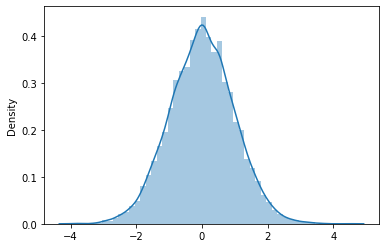

In [ ]:
plt.figure()
sns.distplot(cur_z)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


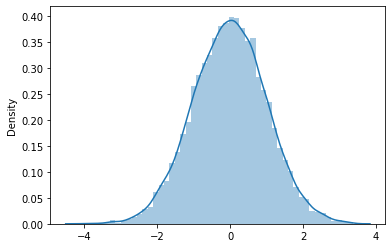

In [ ]:
latent_opt = latent_arr[0].detach().cpu()
plt.figure()
sns.distplot(latent_opt)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


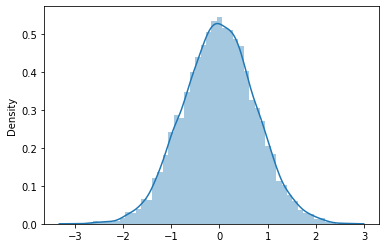

In [ ]:
latent_opt = latent_arr[999].detach().cpu()
plt.figure()
sns.distplot(latent_opt)
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


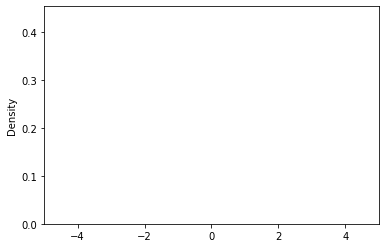

In [ ]:
from celluloid import Camera

fig = plt.figure()
camera = Camera(fig)

# animation draws one data point at a time
for i in range(1, 50):
    plot = sns.distplot(latent_arr[20*i -1].detach().cpu(), color = "b")
    plt.xlim(-5, 5)
    camera.snap()

anim = camera.animate(blit=False)
anim.save("/content/drive/My Drive/Colab Notebooks/GAN_project/imgs/animation_2.mp4")

In [ ]:
latent_arr.shape

torch.Size([1000, 100, 100])

In [ ]:
!pip install celluloid

Distribution에는 큰 변화가 없어 보이지만 분명히 어떤 Optimization이 다른 것에 비해 낫다면 Latent Space의 Feature에 변화가 있었을 것이다. 이것을 Visualization하는 방법을 잘 찾아서 Report를 하면 좋을 것이다.

In [ ]:
latent_opt.shape

torch.Size([100, 100])

In [ ]:
gen_labels = Variable(LongTensor(np.random.randint(0, 10, 100)))
gen_labels

tensor([9, 9, 6, 8, 3, 8, 2, 9, 2, 4, 7, 6, 5, 6, 3, 6, 7, 9, 8, 6, 4, 1, 3, 2,
        3, 9, 8, 3, 9, 3, 1, 1, 7, 3, 6, 8, 0, 7, 9, 9, 5, 8, 8, 5, 7, 6, 5, 9,
        6, 0, 8, 4, 8, 4, 9, 5, 6, 4, 8, 2, 6, 3, 4, 2, 4, 0, 9, 6, 4, 6, 9, 1,
        6, 6, 5, 2, 1, 7, 0, 3, 9, 1, 9, 8, 3, 9, 5, 2, 3, 4, 6, 1, 6, 1, 8, 7,
        7, 3, 3, 9], device='cuda:0')